<a href="https://colab.research.google.com/github/kellydingzx/ecg_notebooks/blob/main/hamilton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import

In [ ]:
! wget -r -N -c -np https://physionet.org/files/nsrdb/1.0.0/
! pip install wfdb
! pip install scipy

In [2]:
import pip
import os

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
import matplotlib.pyplot as plt 

In [5]:
import sys

sys.path.append( '../src' )
import readin
import display
# import algorithms.hamilton

In [6]:
def evaluation(peaks, real_peaks, interval):
    check_peaks = real_peaks[1:]
    n_ref = len(check_peaks)
    n_detected = len(peaks)
    count = 0
    checked_ind = 0
    for i in range(n_detected):
      det_peak = peaks[i]
      for j in range(checked_ind, n_ref):
          correct = check_peaks[j]
          if det_peak > correct -interval and det_peak < correct +interval:
              count +=1
              checked_ind += 1
              break

    sensitivity = count/n_ref
    ppv = count/n_detected
    f1 = 2*ppv*sensitivity/(ppv+sensitivity)
    result = {"sensitivity": str(sensitivity*100)+'%',
              'PPV': str(ppv*100)+'%',
              'F1': str(f1*100) + '%'
              }
    return result

## Example

In [ ]:
example_path = '/content/physionet.org/files/nsrdb/1.0.0/16265'
leads = ['ECG2']
fs=128

n_samples = 30*60*fs
raw_samples, real_peaks= readin.get_data(example_path, leads, 0, n_samples)

In [ ]:
det_peaks = hamilton_detector(raw_samples, fs)
evaluation(det_peaks, real_peaks, 150*(1000/128))

{'sensitivity': '100.0%',
 'PPV': '89.95089549501823%',
 'F1': '94.709630360629%'}

In [20]:
import os
arr = os.listdir('/content/physionet.org/files/nsrdb/1.0.0')

sample_ids = []
for file in arr:
    if '.atr' in file:
        sample_ids.append(file[:5])
        
root_folder = '/content/physionet.org/files/nsrdb/1.0.0'
sensitivity = []
ppv = []
f1 = []

In [ ]:
! pip install neurokit2
import neurokit2 as nk2

In [24]:
def get_peaks(sample_path, leads, fs):
    signal, rest = wfdb.rdsamp(sample_path, sampfrom=0, sampto=None, 
                                channel_names = leads)
    cleaned = nk2.ecg_clean(signal, fs, method='hamilton2002')
    signals, info = nk2.ecg_peaks(cleaned, fs, method='hamilton2002')

    return info["ECG_R_Peaks"]

In [ ]:
for id in sample_ids:
    sample_path = '/content/physionet.org/files/nsrdb/1.0.0/' + id
    leads = ['ECG2']
    fs=128
    n_samples = 4*60*60*fs
    raw_samples, real_peaks= readin.get_data(sample_path, leads, 0, n_samples)
    peaks = get_peaks(sample_path, leads, fs)
    # hamilton_detector(raw_samples, 128)
    print('hi')
    res = evaluation(peaks, real_peaks, int(150/(1000/128)))
    sensitivity.append(res['sensitivity'])
    ppv.append(res['PPV'])
    f1.append(res['F1'])
    print(res)

hi
{'sensitivity': '99.6970309028479%', 'PPV': '19.36654601810709%', 'F1': '32.43287639729616%'}
hi
{'sensitivity': '99.5884113748129%', 'PPV': '18.676945285402088%', 'F1': '31.454812513717478%'}
hi
{'sensitivity': '98.985153166698%', 'PPV': '23.85287031501911%', 'F1': '38.442168876951484%'}
hi
{'sensitivity': '99.38723730192925%', 'PPV': '20.621188343034227%', 'F1': '34.155650793389654%'}


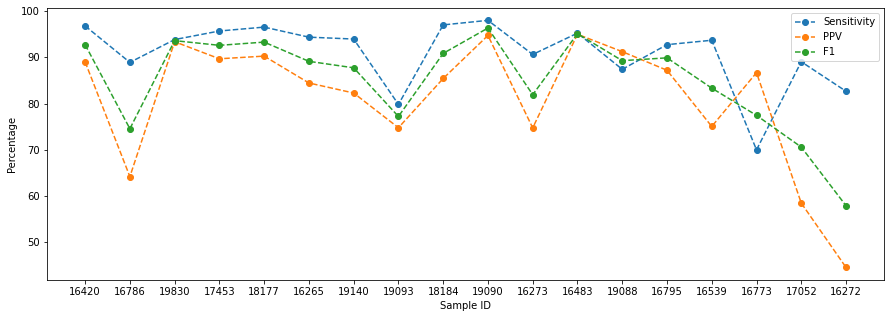

In [17]:
def to_float(arr):
    ret = []
    for x in arr:
        ret.append(float(x[0:-1]))
    return ret 
plt.figure(figsize=(15,5))
plt.xlabel('Sample ID')
plt.ylabel('Percentage')

plt.plot(sample_ids, to_float(sensitivity), label='Sensitivity', marker='o', linestyle='--')
plt.plot(sample_ids, to_float(ppv), label='PPV', marker='o', linestyle='--')
plt.plot(sample_ids, to_float(f1), label='F1', marker='o', linestyle='--')

plt.legend()

In [18]:
np.average(to_float(sensitivity)), np.average(to_float(ppv)), np.average(to_float(f1))

(90.90472143270864, 81.16738024455314, 85.19166149703122)

## Algorithm

In [8]:
import pip

try:
    import wfdb
except ModuleNotFoundError:
    pip.main(['install', "wfdb"])
    import wfdb

import numpy as np
from scipy import signal, ndimage

def hamilton_detector(unfiltered_ecg, sampling_freq):

    filtered_ecg = bandpass_ecg(unfiltered_ecg, 5, 11, sampling_freq)
    diff = differentiated_ecg(unfiltered_ecg, sampling_freq)
    averaged = time_averaged_ecg(unfiltered_ecg, sampling_freq)
    
    n_pks = []
    n_pks_ave = 0.0
    s_pks = []
    s_pks_ave = 0.0
    QRS = [0]
    RR = []
    RR_ave = 0.0

    th = 0.0

    i=0
    idx = []
    peaks = []  

    for i in range(1, len(averaged)-1):

        if averaged[i-1]<averaged[i] and averaged[i+1]<averaged[i]:
            peak = i
            peaks.append(i)

            if averaged[peak] > th and (peak-QRS[-1])>0.3*sampling_freq:        
                QRS.append(peak)
                idx.append(i)
                s_pks.append(averaged[peak])
                if len(n_pks)>8:
                    s_pks.pop(0)
                s_pks_ave = np.mean(s_pks)

                if RR_ave != 0.0:
                    if QRS[-1]-QRS[-2] > 1.5*RR_ave:
                        missed_peaks = peaks[QRS[-1]:QRS[-2]]
                        for missed_peak in missed_peaks:
                            if averaged[missed_peak]>0.3*th:
                                if (missed_peak-peaks[QRS[-2]]< 0.2*sampling_freq and missed_peak-peaks[QRS[-2]] >0.36*sampling_freq) or diff[missed_peak] > 0.5*diff[QRS[-2]]:
                                    QRS.append(missed_peak)
                                    QRS.sort()
                                    break

                if len(QRS)>2:
                    RR.append(QRS[-1]-QRS[-2])
                    if len(RR)>8:
                        RR.pop(0)
                    RR_ave = int(np.median(RR))

            else:
                n_pks.append(averaged[peak])
                if len(n_pks)>8:
                    n_pks.pop(0)
                n_pks_ave = np.mean(n_pks)

            th = n_pks_ave + 0.189*(n_pks_ave-s_pks_ave)


    QRS.pop(0)

    return QRS

def differentiated_ecg(input_signal, sampling_freq):
    diff_signal = input_signal.copy()
    for i in range(len(input_signal)):
        current_sample = 2*input_signal[i]

        if i>=1: current_sample += input_signal[i]
        if i>=3: current_sample -= input_signal[i-3]
        if i>=4: current_sample -= 2*input_signal[i-4]

        diff_signal[i] = current_sample / (8*sampling_freq)
    return diff_signal 

def bandpass_ecg(input_signal, low, high, sampling_freq):
    return high_pass_scipy_butterworth(low_pass_scipy_butterworth(input_signal, high, sampling_freq), low, sampling_freq)

def time_averaged_ecg(input_signal, sampling_freq):
    filtered = bandpass_ecg(input_signal, 5, 11, sampling_freq)
    diffed = differentiated_ecg(filtered, sampling_freq)
    squared = np.square(diffed)
    averaged = avg_ecg(squared, sampling_freq)
    return averaged

def avg_ecg(input_signal, sampling_freq):
    window_size = 32
    input_signal = input_signal.copy()
    moving_avg =  input_signal.copy()
    for index in range(len(input_signal)):
        if index < window_size:
            continue
        else:
            moving_avg[index] = np.sum(input_signal[index-(window_size-1): index+1])
    moving_avg /= window_size
    moving_avg[0: window_size] = 0
    return moving_avg

def low_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(2, cutoff_freq/(sampling_freq/2), 'low', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal

def high_pass_scipy_butterworth(input_signal, cutoff_freq, sampling_freq):
    sos = signal.butter(1, cutoff_freq/(sampling_freq/2), 'high', output='sos')
    filtered_signal = signal.sosfilt(sos, input_signal)
    return filtered_signal
